##### Copyright 2018 The TensorFlow Constrained Optimization Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Wiki Talk Comments Toxicity Prediction

In this example, we consider the task of predicting whether a discussion comment posted on a Wiki talk page contains toxic content (i.e. contains content that is “rude, disrespectful or unreasonable”). We use a public <a href="https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973">dataset</a> released by the <a href="https://conversationai.github.io/">Conversation AI</a> project, which contains over 100k comments from the English Wikipedia that are annotated by crowd workers.

One of the challenges with this dataset is that a very small proportion of the comments in the dataset cover sensitive topics such as sexuality or religion. So, training a neural network model on this dataset by optimizing a simple cross-entropy objective often leads to disparate performance on the smaller sensitive topics. We shall see that by imposing constraints during training, we can train a *fairer* model that enjoys equitable performance across the different topic groups. We shall use the TFCO library to optimize for two different fairness goals during training.

Let's first install and import the relevant libraries.

In [ ]:
#### Reference  https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/

In [ ]:
!pip install git+https://github.com/google-research/tensorflow_constrained_optimization

In [1]:
import io
import os
import shutil
import sys
import tempfile
import zipfile
from urllib import request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
import tensorflow_constrained_optimization as tfco


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate, LSTM
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing import text, sequence
from gensim.models import KeyedVectors
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, Dropout

In [2]:
tf.executing_eagerly()
MODEL_TYPE ='CNN_LSTM' #Specify it to be either CNN, LSTM, BILSTM, 

## Hyper-parameters

Let's fix some hyper-parameters needed for the data preprocessing and model training.

In [3]:
hparams = {
    "batch_size": 256,
    "cnn_filter_sizes": [128],
    "cnn_kernel_sizes": [5],
    "cnn_pooling_sizes": [5],
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 250
}

In [4]:
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'


## Load and pre-process dataset

We next download the dataset and preprocess it. The train, test and validations sets are provided as separate CSV files.

In [5]:
# toxicity_data_url = ("https://raw.githubusercontent.com/conversationai/"
#                      "unintended-ml-bias-analysis/master/data/")

# data_train1 = pd.read_csv(toxicity_data_url + "wiki_train.csv")
# data_test1 = pd.read_csv(toxicity_data_url + "wiki_test.csv")
# data_vali1 = pd.read_csv(toxicity_data_url + "wiki_dev.csv")

# data_train1.head()

In [6]:
data_all = pd.read_csv('/Users/shachatt1/Desktop/sharmi/datascience/CrypTen/fair_data/jigsaw-unintended-bias-in-toxicity-classification/train.csv')

In [7]:
data_all.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [8]:
split_factor = int(np.shape(data_all)[0]*.5)
print(split_factor)
data_train  = data_all[0:split_factor]
data_test_all = data_all[split_factor:]

902437


In [9]:
data_train.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [10]:
data_test_all.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
902437,5223775,0.0,That could be true IF the hack damaged Macron....,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,332501,approved,0,0,0,0,0,0.0,0,4
902438,5223777,0.0,Exposing the not-so-pleasant underbelly of cor...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,331035,approved,0,0,0,0,0,0.0,0,4


In [11]:
split_factor = int(np.shape(data_test_all)[0]*.5)
print(split_factor)
data_vali  = data_test_all[0:split_factor]
data_test = data_test_all[split_factor:]

451218


In [12]:
print("Train data size", np.shape(data_train))
print("Test data size", np.shape(data_test))
print("Validation data size", np.shape(data_vali))

Train data size (902437, 45)
Test data size (451219, 45)
Validation data size (451218, 45)


In [13]:
print(data_train.columns)
print(data_test.columns)
print(data_vali.columns)

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')
Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual',

In [14]:
data_train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [15]:
for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    data_train[column] = np.where(data_train[column] >= 0.5, 1, 0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The `comment` column contains the discussion comments and `is_toxic` column indicates whether or not a comment is annotated as toxic.

In the following, we (i) separate out the labels, (ii) tokenize the text comments, and (iii) identify comments that contain sensitive topic terms.

First, we separate the labels from the train, test and validation sets. The labels are all binary (0 or 1).

In [16]:
labels_train = data_train["target"].values.reshape(-1, 1) * 1.0
labels_test = data_test["target"].values.reshape(-1, 1) * 1.0
labels_vali = data_vali["target"].values.reshape(-1, 1) * 1.0

Next, we tokenize the textual comments using the `Tokenizer` provided by `Keras`. We use the training set comments alone to build a vocabulary of tokens, and use them to convert all the comments into a (padded) sequence of tokens of the same length.

In [17]:
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, num_words=hparams["max_num_words"], lower=False)
#tokenizer.fit_on_texts(list(x_train) + list(x_test))

#tokenizer = text.Tokenizer(num_words=hparams["max_num_words"])
tokenizer.fit_on_texts(data_train["comment_text"])

def prep_text(texts, tokenizer, max_sequence_length):
    # Turns text into into padded sequences.
    text_sequences = tokenizer.texts_to_sequences(texts)
    return sequence.pad_sequences(text_sequences, maxlen=max_sequence_length)

text_train = prep_text(data_train["comment_text"], tokenizer, hparams["max_sequence_length"])
text_test = prep_text(data_test["comment_text"], tokenizer, hparams["max_sequence_length"])
text_vali = prep_text(data_vali["comment_text"], tokenizer, hparams["max_sequence_length"])

Finally, we identify comments belonging to certain sensitive topic groups. We consider a subset of the <a href="https://github.com/conversationai/unintended-ml-bias-analysis/blob/master/unintended_ml_bias/bias_madlibs_data/adjectives_people.txt">identity terms</a> provided with the dataset and group them into
four broad topic groups: *sexuality*, *gender identity*, *religion* and *race*.

In [18]:
terms = {
    'sexuality': ['gay', 'lesbian', 'bisexual', 'homosexual', 'straight', 'heterosexual'],
    'gender identity': ['trans', 'transgender', 'cis', 'nonbinary'],
    'religion': ['christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 'taoist'],
    'race': ['african', 'african american', 'black', 'white', 'european', 'hispanic', 'latino', 'latina',
             'latinx', 'mexican', 'canadian', 'american', 'asian', 'indian', 'middle eastern', 'chinese',
             'japanese'],
     'mental': ['depression', 'anxiety', 'bipolar', 'autism', 'schizophrenia', 'adhd', 'attention-Deficit', 
                'agoraphobia', 'amnesia', 'asperger', 'alcohol abuse', 'alcoholic'],
     'economic': ['poor', 'retired', 'unemployed', 'rich', 'homeless', 'layoffs'],
     'physical': ['cancer', 'arthritis', 'injury', 'disability', 'alzheimer\'s', 'diabetes', 
                  'infertility', 'hiv', 'parkinson', 'herpes', 'ulcers', 'allergies', 'stroke', 'influenza'] }


group_names = list(terms.keys())
num_groups = len(group_names)

We then create separate group membership matrices for the train, test and validation sets, where the rows correspond to comments, the columns correspond to the four sensitive groups, and each entry is a boolean indicating whether the comment contains a term from the topic group.

In [19]:
def get_groups(text):
    # Returns a boolean NumPy array of shape (n, k), where n is the number of comments,
    # and k is the number of groups. Each entry (i, j) indicates if the i-th comment
    # contains a term from the j-th group.
    groups = np.zeros((text.shape[0], num_groups))
    for ii in range(num_groups):
        groups[:, ii] = text.str.contains('|'.join(terms[group_names[ii]]), case=False)
    return groups

groups_train = get_groups(data_train["comment_text"])
groups_test = get_groups(data_test["comment_text"])
groups_vali = get_groups(data_vali["comment_text"])

As shown below, all four topic groups constitute only a small fractions of the overall dataset, and have varying proportions of toxic comments.

In [20]:
print("Overall label proportion = %.1f%%" % (labels_train.mean() * 100))

group_stats = []
for ii in range(num_groups):
    group_proportion = groups_train[:, ii].mean()
    group_pos_proportion = labels_train[groups_train[:, ii] == 1].mean()
    group_stats.append([group_names[ii],
                        "%.2f%%" % (group_proportion * 100),
                        "%.1f%%" % (group_pos_proportion * 100)])
group_stats = pd.DataFrame(group_stats,
                           columns=["Topic group", "Group proportion", "Label proportion"])
group_stats

Overall label proportion = 7.8%


,Topic group,Group proportion,Label proportion
0,sexuality,0.92%,19.7%
1,gender identity,6.29%,11.2%
2,religion,3.14%,13.5%
3,race,9.67%,11.8%
4,mental,0.27%,7.1%
5,economic,3.97%,7.8%
6,physical,0.61%,7.1%


In particular, only 1.3% of the dataset contains comments related to sexuality. Among them, 37% of the comments have been annotated as being toxic. Note that this is significantly larger than the overall proportion of comments annotated as toxic.

## Build CNN/LSTM/BI-LSTM/LSTM_CNN/BI_LSTM_CNN toxicity prediction model

Having prepared the dataset, we now build a `Keras` model for prediction toxicity. The model we use is a convolutional neural network (CNN) with the same architecture used by the Conversation AI project for their debiasing analysis. We adapt <a href="https://github.com/conversationai/unintended-ml-bias-analysis/blob/master/unintended_ml_bias/model_tool.py">code</a> provided by them to construct the model layers.

The model uses an embedding layer to convert the text tokens to fixed-length vectors. This layer converts the input text sequence into a sequence of vectors, and passes them through several layers of convolution and pooling operations, followed by a final fully-connected layer.

We make use of pre-trained GloVe word vector emebeddings, which we download below. This may take a few minutes to complete!

In [21]:
zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
zip_file = request.urlopen(zip_file_url)
archive = zipfile.ZipFile(io.BytesIO(zip_file.read()))

We use the the downloaded GloVe embeddings to create an embedding matrix, where the rows contain the word embeddings for the tokens in the `Tokenizer`'s vocabulary. 

In [22]:
embeddings_index = {}
glove_file = "glove.6B.100d.txt"

with archive.open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0].decode("utf-8")
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, hparams["embedding_dim"]))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[i] = embedding_vector

We are now ready to specify the `Keras` layers. We write a function to create a new model, which we will invoke whenever we wish to train a new model.

In [24]:
def build_cnn_model():
    model = keras.Sequential()

    # Embedding layer.
    embedding_layer = layers.Embedding(
        embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix],
        input_length=hparams["max_sequence_length"], trainable=hparams['embedding_trainable'])
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'], hparams['cnn_pooling_sizes']):

        conv_layer = layers.Conv1D(filter_size, kernel_size, activation='relu', padding='same')
        model.add(conv_layer)

        pooled_layer = layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))

    return model

In [25]:
def build_lstm_model():  
    # define the model
    # Embedding layer.
    model = keras.Sequential()
    embedding_layer = layers.Embedding(
        embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix],
        input_length=hparams["max_sequence_length"], trainable=hparams['embedding_trainable'])
    model.add(embedding_layer)
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [26]:
def build_bi_lstm_model():  
    # define the model
    # Embedding layer.
    model = keras.Sequential()
    embedding_layer = layers.Embedding(
        embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix],
        input_length=hparams["max_sequence_length"], trainable=hparams['embedding_trainable'])
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.25))
    model.add(layers.Dense(1))
    return model

In [23]:
def build_lstm_cnn():
    
    model = keras.Sequential()
    embedding_layer = layers.Embedding(
        embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix],
        input_length=hparams["max_sequence_length"], trainable=hparams['embedding_trainable'])
    model.add(embedding_layer)
    
    model.add(Dropout(0.2))
    model.add(layers.Conv1D(64, 5, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=4))
    model.add(LSTM(100))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [27]:
def build_bi_lstm_cnn():
    
    model = keras.Sequential()
    embedding_layer = layers.Embedding(
        embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix],
        input_length=hparams["max_sequence_length"], trainable=hparams['embedding_trainable'])
    model.add(embedding_layer)
    
    model.add(SpatialDropout1D(0.2))    
    #model.add(layers.Conv1D(64, 5, activation='relu'))
    conv_layer = layers.Conv1D(128, 5, activation='relu', padding='same')
    model.add(conv_layer)
    model.add(layers.MaxPooling1D(pool_size=5))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.25))
    model.add(layers.Dense(1))
    return model

## Evaluation and plotting functions

Before proceeding to training the model, we will write functions to evaluate the overall error rate, the overall false negative rate and the overall false positive rate for the given labels and predictions. We also include functions to evaluate the false positive and false negative rates for individual groups.

In [28]:
def error_rate(labels, predictions):
    # Returns error rate for given labels and predictions.
    # Recall that the labels are binary (0 or 1).
    signed_labels = (labels * 2) - 1
    return np.mean(signed_labels * predictions <= 0.0)


def false_negative_rate(labels, predictions):
    # Returns false negative rate for given labels and predictions.
    if np.sum(labels > 0) == 0:  # Any positives?
        return 0.0
    else:
        return np.mean(predictions[labels > 0] <= 0)


def false_positive_rate(labels, predictions):
    # Returns false positive rate for given labels and predictions.
    if np.sum(labels <= 0) == 0:  # Any negatives?
        return 0.0
    else:
        return np.mean(predictions[labels <= 0] > 0)


def group_false_negative_rates(labels, predictions, groups):
    # Returns list of per-group false negative rates for given labels,
    # predictions and group membership matrix.
    fnrs = []
    for ii in range(groups.shape[1]):
        labels_ii = labels[groups[:, ii] == 1]
        if np.sum(labels_ii > 0) > 0:  # Any positives?
            predictions_ii = predictions[groups[:, ii] == 1]
            fnr_ii = np.mean(predictions_ii[labels_ii > 0] <= 0)
        else:
            fnr_ii = 0.0
        fnrs.append(fnr_ii)
    return fnrs


def group_false_positive_rates(labels, predictions, groups):
    # Returns list of per-group false positive rates for given labels,
    # predictions and group membership matrix.
    fprs = []
    for ii in range(groups.shape[1]):
        labels_ii = labels[groups[:, ii] == 1]
        if np.sum(labels_ii <= 0) > 0:  # Any negatives?
            predictions_ii = predictions[groups[:, ii] == 1]
            fpr_ii = np.mean(predictions_ii[labels_ii <= 0] > 0)
        else:
            fpr_ii = 0.0
        fprs.append(fpr_ii)
    return fprs

We also write a function to generate a bar plot of the above metrics for given labels, predictions and group information. 

In [29]:
# Set plot fonts.
plt.rcParams['font.sans-serif'] = "Liberation Sans"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 13

# Color-blind friendly color palette from https://gist.github.com/thriveth/8560036
cb_palette = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3",
              "#e41a1c", "#dede00", "#999999"]

In [30]:
def plot_metrics(labels, predictions, groups, group_names, title):
    # Plot overall FPR, overall FNR, per-group FPRs, per-group FNRs for given labels,
    # predictions, group membership matrix, group names, and plot title.

    # Evaluate all the above metrics.
    overall_error = error_rate(labels, predictions)
    overall_fpr = false_positive_rate(labels, predictions)
    overall_fnr = false_negative_rate(labels, predictions)
    group_fprs = group_false_positive_rates(labels, predictions, groups)
    group_fnrs = group_false_negative_rates(labels, predictions, groups)

    # Plot bar plot overall and per-group FPRs and FNRs.
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    fpr_percentages = [x * 100 for x in [overall_fpr] + group_fprs]
    fnr_percentages = [x * 100 for x in [overall_fnr] + group_fnrs]

    ax[0].barh(-np.arange(len(group_names) + 1), fpr_percentages, color=cb_palette)
    ax[0].set_yticks(-np.arange(len(group_names) + 1))
    ax[0].set_yticklabels(["overall"] + group_names)
    ax[0].set_xlabel("False Positive Rate %")
    ax[0].set_xlim([0, max(10, max(fpr_percentages) + 1)])

    ax[1].barh(-np.arange(len(group_names) + 1), fnr_percentages, color=cb_palette)
    ax[1].set_yticks(-np.arange(len(group_names) + 1))
    ax[1].set_yticklabels(["overall"] + group_names)
    ax[1].set_xlabel("False Negative Rate %")
    ax[1].set_xlim([0, max(fnr_percentages) + 1])

    fig.tight_layout()

    # Specify accuracy rate in the plot title.
    fig.suptitle(title + ": Accuracy = %.2f%%" % ((1 - overall_error) * 100),
                 x=0.55, y=1.1)

## Train unconstrained model

For the first model we train, we optimize a simple cross-entropy loss *without* any constraints.

**Note**: The following code cell may take several minutes to run.

In [ ]:
# Set random seed for reproducible results.
np.random.seed(121212)
tf.compat.v1.random.set_random_seed(212121)

# Optimizer and loss.
optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
loss = lambda y_true, y_pred: tf.keras.losses.binary_crossentropy(
    y_true, y_pred, from_logits=True)

# Create, compile and fit model.
if(MODEL_TYPE == 'CNN'):
    model_unconstrained = build_cnn_model()
if(MODEL_TYPE == 'LSTM'):
    model_unconstrained = build_lstm_model()
if(MODEL_TYPE == 'BILSTM'):
    model_unconstrained = build_bi_lstm_model()
if(MODEL_TYPE == 'CNN_LSTM'):
    model_unconstrained = build_lstm_cnn()
if(MODEL_TYPE == 'CNN_BILSTM'):
    model_unconstrained = build_bi_lstm_cnn()
    
model_unconstrained.compile(optimizer=optimizer, loss=loss)
model_unconstrained.fit(
    x=text_train, y=labels_train, batch_size=hparams["batch_size"], epochs=2)

# CNN

W0621 17:17:45.433134 4751881664 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
W0621 17:17:45.554798 4751881664 font_manager.py:1282] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


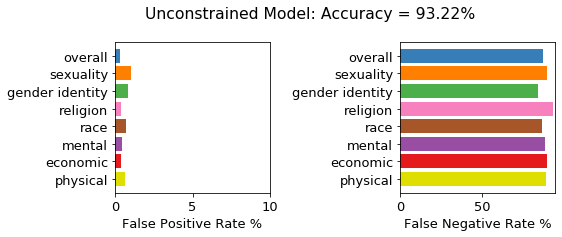

In [32]:
scores_unconstrained_test = model_unconstrained.predict(text_test)
plot_metrics(labels_test, scores_unconstrained_test, groups_test, group_names,
             "CNN Unconstrained Model")

# Bi-Directional LSTM

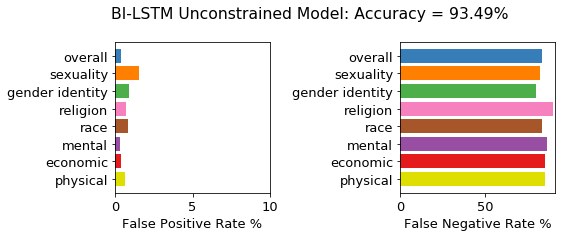

In [112]:
scores_unconstrained_test = model_unconstrained.predict(text_test)
plot_metrics(labels_test, scores_unconstrained_test, groups_test, group_names,
             "BI-LSTM Unconstrained Model")

Having trained the unconstrained model, we plot various evaluation metrics for the model on the test set.

# Simple LSTM

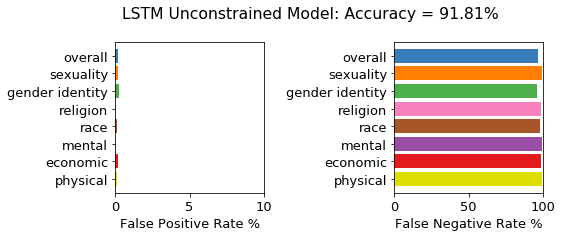

In [80]:
scores_unconstrained_test = model_unconstrained.predict(text_test)
plot_metrics(labels_test, scores_unconstrained_test, groups_test, group_names,
             "LSTM Unconstrained Model")

## Train with constraints on false positive rates

To avoid large differences in false positive rates across different groups, we
next train a model by constraining the false positive rates for each group to be within a desired limit. Specifically, we optimize the error rate of the model subject to the *per-group false positive rates being lesser or equal to 2%*.

Performing minibatch training with per-group constraints can however be challenging for this dataset, as the groups we wish to constraint are all small in size, and its likely that the individual minibatches contains very few examples from each group. Hence the gradients we compute during training will be noisy, and result in the model converging very slowly.

To mitigate this problem, we recommend using two streams of minibatches, with the first stream formed as before from the entire training set, and the second stream formed solely from the sensitive group examples. We will compute the objective using minibatches from the first stream and the per-group constraints using minibatches from the second stream. Because the batches from the second stream are likely to contain larger number of examples from each group, we expect our updates to be less noisy. This strategy is similar to the one described in the <a href="https://github.com/google-research/tensorflow_constrained_optimization/tree/master/examples/jupyter/Minibatch_training.ipynb">Minibatch_training.ipynb</a> notebook.

We create separate features, labels and groups tensors to hold the minibatches from the two streams.

In [113]:
# Set random seed.
np.random.seed(121212)
tf.compat.v1.random.set_random_seed(212121)

# Features tensors.
batch_shape = (hparams["batch_size"], hparams['max_sequence_length'])
features_tensor = tf.Variable(np.zeros(batch_shape, dtype='int32'), name='x')
features_tensor_sen = tf.Variable(np.zeros(batch_shape, dtype='int32'), name='x_sen')

# Labels tensors.
batch_shape = (hparams["batch_size"], 1)
labels_tensor = tf.Variable(np.zeros(batch_shape, dtype='float32'), name='labels')
labels_tensor_sen = tf.Variable(np.zeros(batch_shape, dtype='float32'), name='labels_sen')

# Groups tensors.
batch_shape = (hparams["batch_size"], num_groups)
groups_tensor_sen = tf.Variable(np.zeros(batch_shape, dtype='float32'), name='groups_sen')

We instantiate a new model, and compute predictions for minibatches from the two streams.

In [114]:
# Create model, and separate prediction functions for the two streams.
# For the predictions, we use a nullary function returning a Tensor to support eager mode.
# Create, compile and fit model.
if(MODEL_TYPE == 'CNN'):
    model_constrained = build_cnn_model()
if(MODEL_TYPE == 'LSTM'):
    model_constrained = build_lstm_model()
if(MODEL_TYPE == 'BILSTM'):
    model_constrained = build_bi_lstm_model()
if(MODEL_TYPE == 'CNN_LSTM'):
    model_constrained = build_lstm_cnn()
if(MODEL_TYPE == 'CNN_BILSTM'):
    model_constrained = build_bi_lstm_cnn()

def predictions():
  return model_constrained(features_tensor)

def predictions_sen():
  return model_constrained(features_tensor_sen)

We then set up a constrained optimization problem with the error rate as the objective and with constraints on the per-group false positive rate.

In [115]:
epsilon = 0.02  # Desired false-positive rate threshold.

# Set up separate contexts for the two minibatch streams.
context = tfco.rate_context(predictions, lambda: labels_tensor)
context_sen = tfco.rate_context(predictions_sen, lambda: labels_tensor_sen)

# Compute the objective using the first stream.
objective = tfco.error_rate(context)

# Compute the constraints using the second stream.
# For each group, subset the examples belonging to that group from the second stream,
# and add a constraint on the group's false positive rate.
constraints = []
for ii in range(num_groups):
    context_sen_subset = context_sen.subset(
        lambda kk=ii: groups_tensor_sen[:, kk] > 0)
    # We pass the group index ii as a default argument to the the function, so
    # that the function retains a local copy of this variable, and is unaffected
    # by changes to the variable outside the function.
    constraints.append(
        tfco.false_positive_rate(context_sen_subset) <= epsilon)

# Create a rate minimization problem.
problem = tfco.RateMinimizationProblem(objective, constraints)

# Set up a constrained optimizer.
optimizer = tfco.ProxyLagrangianOptimizerV2(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"]),
    num_constraints=problem.num_constraints)

# List of variables to optimize include the model weights,
# and the trainable variables from the rate minimization problem and
# the constrained optimizer.
var_list = (model_constrained.trainable_weights + problem.trainable_variables +
            optimizer.trainable_variables())

We are ready to train the model. We maintain a separate counter for the two minibatch streams. Every time we perform a gradient update, we will have to copy the minibatch contents from the first stream to the tensors `features_tensor` and `labels_tensor`, and the minibatch contents from the second stream to the tensors `features_tensor_sen`, `labels_tensor_sen` and `groups_tensor_sen`.

Also note since we are solving a constrained optimization problem, the final iterate from training  may not always be the best solution, and an intermediate iterate may do a better job of optimizing objective while satisfying the constraints. So, we periodically snapshot the model parameters and evaluate its performance on the validation set. At the end of training, we choose the best iterate from the recorded snapshots using a heuristic provided the TF constrained optimization library.

**Note**: The following code cell may take several minutes to run.

In [116]:
# Create temporary directory to record model snapshots.
temp_directory = tempfile.mktemp()
os.mkdir(temp_directory)

# Indices of sensitive group members.
protected_group_indices = np.nonzero(groups_train.sum(axis=1))[0]

num_examples = text_train.shape[0]
num_examples_sen = protected_group_indices.shape[0]
batch_size = hparams["batch_size"]

# Number of steps needed for one epoch over the training sample.
num_steps = int(num_examples / batch_size)

# Number of steps to skip before check-pointing the current model.
skip_steps = int(num_steps / 10)

# List of recorded objectives and constrained violations.
objectives_list = []
violations_list = []

start_time = time.time()

# Loop over minibatches.
for batch_index in range(num_steps):
    # Indices for current minibatch in the first stream.
    batch_indices = np.arange(batch_index * batch_size, (batch_index + 1) * batch_size)
    batch_indices = [ind % num_examples for ind in batch_indices]

    # Indices for current minibatch in the second stream.
    batch_indices_sen = np.arange(batch_index * batch_size, (batch_index + 1) * batch_size)
    batch_indices_sen = [protected_group_indices[ind % num_examples_sen]
                         for ind in batch_indices_sen]

    # Assign features, labels, groups from the minibatches to the respective tensors.
    features_tensor.assign(text_train[batch_indices, :])
    labels_tensor.assign(labels_train[batch_indices])

    features_tensor_sen.assign(text_train[batch_indices_sen, :])
    labels_tensor_sen.assign(labels_train[batch_indices_sen])
    groups_tensor_sen.assign(groups_train[batch_indices_sen, :])

    # Gradient update.
    optimizer.minimize(problem, var_list=var_list)

    # Once in every skip_steps iterations, snapshot model parameters
    # and evaluate objective and constraint violations on validation set.
    if batch_index % skip_steps == 0:
        # Evaluate model on validation set.
        scores_vali = model_constrained.predict(text_vali)

        error = error_rate(labels_vali, scores_vali)  # Error rate
        group_fprs = group_false_positive_rates(
            labels_vali, scores_vali, groups_vali)
        violations = [z - epsilon for z in group_fprs]  # FPR constraint violations

        objectives_list.append(error)
        violations_list.append(violations)

        # Save model weights to temporary directory.
        model_constrained.save_weights(
            temp_directory + "constrained_" +
            str(int(batch_index / skip_steps)) + ".h5")

    # Display most recently recorded objective and max violation in constraints.
    elapsed_time = time.time() - start_time
    sys.stdout.write(
        "\rIteration %d / %d: Elapsed time = %d secs, Error = %.3f, Violation = %.3f " %
        (batch_index + 1, num_steps, elapsed_time, objectives_list[-1], 
         max(violations_list[-1])))

# Select the beszt model from the recorded iterates using TFCO's find best
# candidates heuristic.
best_index = tfco.find_best_candidate_index(
    np.array(objectives_list), np.array(violations_list), rank_objectives=False)

# Load model weights for the best iterate from the snapshots saved previously.
model_constrained.load_weights(
    temp_directory + "constrained_" + str(best_index) + ".h5")

Iteration 3525 / 3525: Elapsed time = 58082 secs, Error = 0.061, Violation = -0.015 

Having trained the constrained model, we plot various evaluation metrics for the model on the test set.

# CNN

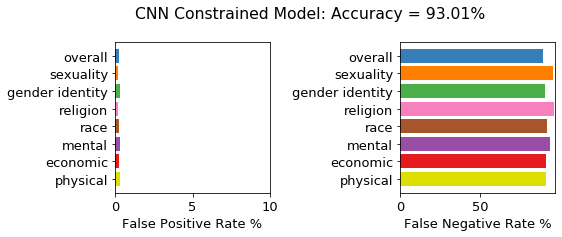

In [76]:
scores_constrained_test = model_constrained.predict(text_test)
plot_metrics(labels_test, scores_constrained_test, groups_test, group_names,
             "CNN Constrained Model")

Below, we present a side-by-side comparison of the plots for the unconstrained and constrained models.

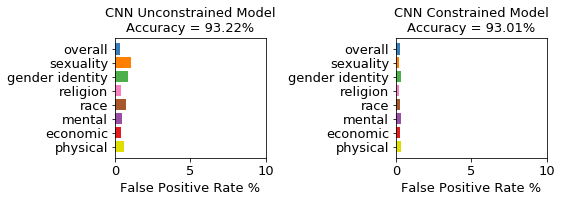

In [77]:
# Evaluate all evaluation metrics.
overall_error1 = error_rate(labels_test, scores_unconstrained_test)
overall_error2 = error_rate(labels_test, scores_constrained_test)

overall_fpr1 = false_positive_rate(labels_test, scores_unconstrained_test)
overall_fpr2 = false_positive_rate(labels_test, scores_constrained_test)

group_fprs1 = group_false_positive_rates(labels_test, scores_unconstrained_test, groups_test)
group_fprs2 = group_false_positive_rates(labels_test, scores_constrained_test, groups_test)

# Plot FPRs and FNRs.
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

fpr_percentages1 = [x * 100 for x in [overall_fpr1] + group_fprs1]
fpr_percentages2 = [x * 100 for x in [overall_fpr2] + group_fprs2]

ax[0].barh(-np.arange(len(group_names) + 1), fpr_percentages1, color=cb_palette)
ax[0].set_yticks(-np.arange(len(group_names) + 1))
ax[0].set_yticklabels(["overall"] + group_names)
ax[0].set_xlabel("False Positive Rate %")
ax[0].set_xlim([0, max(10, max(fpr_percentages1) + 1)])
ax[0].set_title("CNN Unconstrained Model\nAccuracy = %.2f%%" % ((1 - overall_error1) * 100),
                fontsize=13)

ax[1].barh(-np.arange(len(group_names) + 1), fpr_percentages2, color=cb_palette)
ax[1].set_yticks(-np.arange(len(group_names) + 1))
ax[1].set_yticklabels(["overall"] + group_names)
ax[1].set_xlabel("False Positive Rate %")
ax[1].set_xlim([0, max(10, max(fpr_percentages2) + 1)])
ax[1].set_title("CNN Constrained Model\nAccuracy = %.2f%%" % ((1 - overall_error2) * 100),
                fontsize=13)

fig.tight_layout()

# LSTM

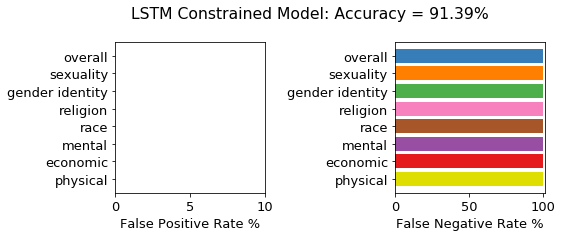

In [85]:
scores_constrained_test = model_constrained.predict(text_test)
plot_metrics(labels_test, scores_constrained_test, groups_test, group_names,
             "LSTM Constrained Model")

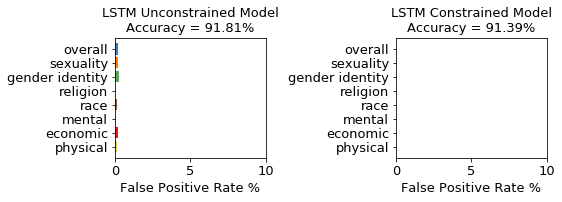

In [86]:
# Evaluate all evaluation metrics.
overall_error1 = error_rate(labels_test, scores_unconstrained_test)
overall_error2 = error_rate(labels_test, scores_constrained_test)

overall_fpr1 = false_positive_rate(labels_test, scores_unconstrained_test)
overall_fpr2 = false_positive_rate(labels_test, scores_constrained_test)

group_fprs1 = group_false_positive_rates(labels_test, scores_unconstrained_test, groups_test)
group_fprs2 = group_false_positive_rates(labels_test, scores_constrained_test, groups_test)

# Plot FPRs and FNRs.
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

fpr_percentages1 = [x * 100 for x in [overall_fpr1] + group_fprs1]
fpr_percentages2 = [x * 100 for x in [overall_fpr2] + group_fprs2]

ax[0].barh(-np.arange(len(group_names) + 1), fpr_percentages1, color=cb_palette)
ax[0].set_yticks(-np.arange(len(group_names) + 1))
ax[0].set_yticklabels(["overall"] + group_names)
ax[0].set_xlabel("False Positive Rate %")
ax[0].set_xlim([0, max(10, max(fpr_percentages1) + 1)])
ax[0].set_title("LSTM Unconstrained Model\nAccuracy = %.2f%%" % ((1 - overall_error1) * 100),
                fontsize=13)

ax[1].barh(-np.arange(len(group_names) + 1), fpr_percentages2, color=cb_palette)
ax[1].set_yticks(-np.arange(len(group_names) + 1))
ax[1].set_yticklabels(["overall"] + group_names)
ax[1].set_xlabel("False Positive Rate %")
ax[1].set_xlim([0, max(10, max(fpr_percentages2) + 1)])
ax[1].set_title("LSTM Constrained Model\nAccuracy = %.2f%%" % ((1 - overall_error2) * 100),
                fontsize=13)

fig.tight_layout()

# BI-LSTM

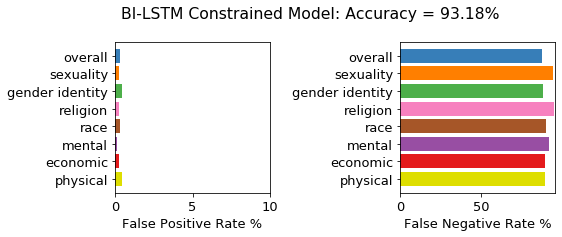

In [117]:
scores_constrained_test = model_constrained.predict(text_test)
plot_metrics(labels_test, scores_constrained_test, groups_test, group_names,
             "BI-LSTM Constrained Model")

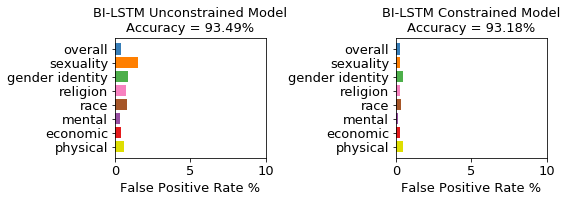

In [118]:
# Evaluate all evaluation metrics.
overall_error1 = error_rate(labels_test, scores_unconstrained_test)
overall_error2 = error_rate(labels_test, scores_constrained_test)

overall_fpr1 = false_positive_rate(labels_test, scores_unconstrained_test)
overall_fpr2 = false_positive_rate(labels_test, scores_constrained_test)

group_fprs1 = group_false_positive_rates(labels_test, scores_unconstrained_test, groups_test)
group_fprs2 = group_false_positive_rates(labels_test, scores_constrained_test, groups_test)

# Plot FPRs and FNRs.
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

fpr_percentages1 = [x * 100 for x in [overall_fpr1] + group_fprs1]
fpr_percentages2 = [x * 100 for x in [overall_fpr2] + group_fprs2]

ax[0].barh(-np.arange(len(group_names) + 1), fpr_percentages1, color=cb_palette)
ax[0].set_yticks(-np.arange(len(group_names) + 1))
ax[0].set_yticklabels(["overall"] + group_names)
ax[0].set_xlabel("False Positive Rate %")
ax[0].set_xlim([0, max(10, max(fpr_percentages1) + 1)])
ax[0].set_title("BI-LSTM Unconstrained Model\nAccuracy = %.2f%%" % ((1 - overall_error1) * 100),
                fontsize=13)

ax[1].barh(-np.arange(len(group_names) + 1), fpr_percentages2, color=cb_palette)
ax[1].set_yticks(-np.arange(len(group_names) + 1))
ax[1].set_yticklabels(["overall"] + group_names)
ax[1].set_xlabel("False Positive Rate %")
ax[1].set_xlim([0, max(10, max(fpr_percentages2) + 1)])
ax[1].set_title("BI-LSTM Constrained Model\nAccuracy = %.2f%%" % ((1 - overall_error2) * 100),
                fontsize=13)

fig.tight_layout()

Compared to the unconstrained model, the constrained model yields significantly lower false positive rates for the sexuality-related comments, and does so with only a slight dip in the overall accuracy.

## Train with robust optimization

We have seen that by using constrained optimization, we can learn a model that has low false positive rates (FPRs) for all groups. However, the models we have trained so far all have high false negative rates (FNRs). We could try training a model with additional constraints on the per-group FNRs, but this is likely to overconstrain the model and produce a trivial solution, such as e.g. a model that makes the same prediction on all inputs.

Instead, a more reasonable solution would be to train a model by optimizing for the worst-case  metric, i.e. minimizing the worst among all the metrics we care about. In the following, we seek to optimize the mean of the worst-case FPR and the worst-case FNR, i.e. the mean of the maximum among *the overall FPR* and *the FPRs for individual groups*, and the maximum among *the overall FNR* and *the FNRs for individual groups*. More formally, this can be stated as:

$$
minimize \text{       }\frac{1}{2}max\big\{OverallFPR, FPR(sexuality), \ldots\big\} + \frac{1}{2}\max\big\{OverallFNR, FNR(sexuality), \ldots\big\}.
$$

Since the goal here is to be robust to a set of different evaluation metrics, problems of this form are often referred to as *robust optimization problems*.

Below, we solve the above robust optimization problem using the TF constrained optimization library. We once again use two streams of minibatches to better handle the small group sizes.

In [119]:
# Set random seed.
np.random.seed(121212)
#tf.compat.v1.random.set_random_seed(212121)

# Features tensor.
batch_shape = (hparams["batch_size"], hparams['max_sequence_length'])
features_tensor = tf.Variable(np.zeros(batch_shape, dtype='int32'), name='x')
features_tensor_sen = tf.Variable(np.zeros(batch_shape, dtype='int32'), name='x_sen')

# Label tensors.
batch_shape = (hparams["batch_size"], 1)
labels_tensor = tf.Variable(np.zeros(batch_shape, dtype='float32'), name='labels')
labels_tensor_sen = tf.Variable(np.zeros(batch_shape, dtype='float32'), name='labels_sen')

# Group tensors.
batch_shape = (hparams["batch_size"], num_groups)
groups_tensor_sen = tf.Variable(np.zeros(batch_shape, dtype='float32'), name='groups_sen')

# Create model and predictions functions.
if(MODEL_TYPE == 'CNN'):
    model_robust = build_cnn_model()
if(MODEL_TYPE == 'LSTM'):
    model_robust = build_lstm_model()
if(MODEL_TYPE == 'BILSTM'):
    model_robust = build_bi_lstm_model()
if(MODEL_TYPE == 'CNN_LSTM'):
    model_robust = build_lstm_cnn()
if(MODEL_TYPE == 'CNN_BILSTM'):
    model_robust = build_bi_lstm_cnn()

def predictions():
  return model_robust(features_tensor)

def predictions_sen():
  return model_robust(features_tensor_sen)

We formulate a rate minimization problem by creating a list of rate metrics we are interested in and using `tfco.upper_bound` to define the maximum of these metrics as the optimization objective.

In [120]:
# Set up separate contexts for the two minibatch streams.
context = tfco.rate_context(predictions, lambda: labels_tensor)
context_sen = tfco.rate_context(predictions_sen, lambda: labels_tensor_sen)

# List of metrics we are interested in.
fprs = []
fnrs = []

# Add overall FPR and overall FNR, computed using the first stream.
fprs.append(tfco.false_positive_rate(context))
fnrs.append(tfco.false_negative_rate(context))

# Add group-specific FPRs and FNRs, computed using the second stream.
for ii in range(num_groups):
    context_sen_subset = context_sen.subset(
        lambda kk=ii: groups_tensor_sen[:, kk] > 0)
    # We pass the group index ii as a default argument to the the function, so
    # that the function retains a local copy of this variable, and is unaffected
    # by changes to the variable outside the function.
    fprs.append(tfco.false_positive_rate(context_sen_subset))
    fnrs.append(tfco.false_negative_rate(context_sen_subset))

# Set up optimization problem with the "max" of all the metrics as the objective.
problem = tfco.RateMinimizationProblem(
    0.5 * tfco.upper_bound(fprs) + 0.5 * tfco.upper_bound(fnrs))

# Set up constrained optimizer.
optimizer = tfco.ProxyLagrangianOptimizerV2(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"]),
    num_constraints=problem.num_constraints)

# List of variables to optimize include the model weights,
# and the trainable variables from the rate minimization problem and
# the constrained optimizer.
var_list = (model_robust.trainable_weights + problem.trainable_variables +
            optimizer.trainable_variables())

During training, we periodically snapshot the model parameters and evaluate the worst-case metric value (i.e. the "max" objective) on the validation set. At the end of training, we choose the iterate that yields the minimum worst-case metric.

**Note**: The following code cell may take several minutes to run.

In [121]:
# Create temporary directory for snapshotting models.
temp_directory = tempfile.mktemp()
os.mkdir(temp_directory)

# Indices of sensitive group members.
protected_group_indices = np.nonzero(groups_train.sum(axis=1))[0]

num_examples = text_train.shape[0]
num_examples_sen = protected_group_indices.shape[0]
batch_size = hparams["batch_size"]

# Number of steps needed for one epoch over the training sample.
num_steps = int(num_examples / batch_size)

# Number of steps after which to snap-shot the model.
skip_steps = int(num_steps / 10)

# List of recorded robust optimization objectives.
objectives_list = []

start_time = time.time()

# Loop over minibatches.
for batch_index in range(num_steps):
    # Indices for current minibatch in the first stream.
    batch_indices = np.arange(batch_index * batch_size, (batch_index + 1) * batch_size)
    batch_indices = [ind % num_examples for ind in batch_indices]

    # Indices for current minibatch in the second stream.
    batch_indices_sen = np.arange(batch_index * batch_size, (batch_index + 1) * batch_size)
    batch_indices_sen = [protected_group_indices[ind % num_examples_sen]
                         for ind in batch_indices_sen]

    # Assign features, labels, groups from the minibatches to the respective tensors.
    features_tensor.assign(text_train[batch_indices, :])
    labels_tensor.assign(labels_train[batch_indices])

    features_tensor_sen.assign(text_train[batch_indices_sen, :])
    labels_tensor_sen.assign(labels_train[batch_indices_sen])
    groups_tensor_sen.assign(groups_train[batch_indices_sen, :])

    # Gradient update.
    optimizer.minimize(problem, var_list=var_list)

    # Once in every skip_steps steps, snapshot model parameters
    # and evaluate robust optimization objective on the validation set.
    all_fprs = []
    all_fnrs = []

    if batch_index % skip_steps == 0:
        # Evaluate on validation set.
        scores_vali = model_robust.predict(text_vali)

        fpr = false_positive_rate(labels_vali, scores_vali)
        all_fprs += [fpr]

        fnr = false_negative_rate(labels_vali, scores_vali)
        all_fnrs += [fnr]

        group_fprs = group_false_positive_rates(labels_vali, scores_vali, groups_vali)
        group_fprs = [group_fprs[jj] for jj in range(num_groups)]
        all_fprs += group_fprs

        group_fnrs = group_false_negative_rates(labels_vali, scores_vali, groups_vali)
        group_fnrs = [group_fnrs[jj] for jj in range(num_groups)]
        all_fnrs += group_fnrs

        objectives_list.append(0.5 * max(all_fprs) + 0.5 * max(all_fnrs))

        # Save model weights to temporary directory.
        model_robust.save_weights(
            temp_directory + "/robust_" +
            str(int(batch_index / skip_steps)) + ".h5")

    # Display most recently recorded objective.
    elapsed_time = time.time() - start_time
    sys.stdout.write(
        "\rIteration %d / %d: Elapsed time = %d secs, Max objective = %.3f " %
        (batch_index + 1, num_steps, elapsed_time, objectives_list[-1]))

# Select the best model from the recorded iterates. Pick the one with the
# minimum "max objective", and load its weights.
best_index = np.argmin(objectives_list)
model_robust.load_weights(temp_directory + "/robust_" + str(best_index) + ".h5")

# Remove temporary directory.
shutil.rmtree(temp_directory)

Iteration 3525 / 3525: Elapsed time = 37140 secs, Max objective = 0.419 

We plot various evaluation metrics for the trained model on the test set.

# LSTM

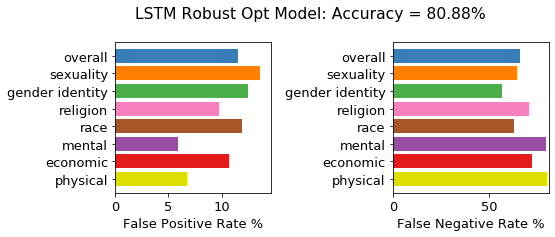

In [90]:
scores_test = model_robust.predict(text_test)
plot_metrics(labels_test, scores_test, groups_test, group_names, "LSTM Robust Opt Model")

# CNN

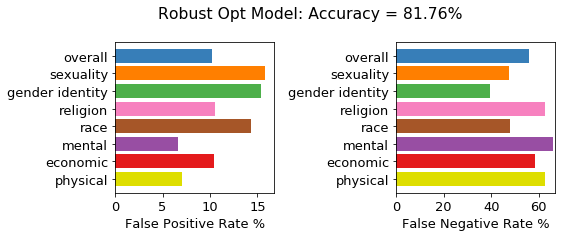

In [45]:
scores_test = model_robust.predict(text_test)
plot_metrics(labels_test, scores_test, groups_test, group_names, "CNN Robust Opt Model")

# BI-LSTM

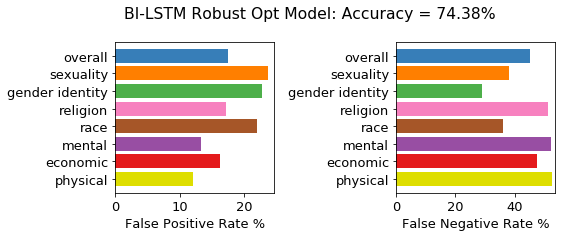

In [122]:
scores_test = model_robust.predict(text_test)
plot_metrics(labels_test, scores_test, groups_test, group_names, "BI-LSTM Robust Opt Model")

Compared to the two previous models, we can see a significant reduction in the false negative rates. This however comes at the cost of a lower accuracy and higher false positive rates. Indeed the trained model performs the best on the training objective that we sought to minimize. 

Note that if low false positive rates are more important than low false negative rates, one can modify the training objective to have a higher weight on the maximum FPR term than the maximum FNR term.

## CNN Performance on finer groups

We close this tutorial by noting that while constrained and robust optimization are effective means to enforce different fairness goals, with both these approaches, you at best get what you ask for!

For example, with the robust optimization problem that we solved above, we observed that none of the four topic groups incurred a false positive rate or a false negative rate of more than 35%. However, the same may not hold for the finer sub-groups within these groups. Let's take a closer look at sub-groups within the *sexuality* topic group.

In [62]:
# We treat each identity term related to "sexuality" as a separate sub-group.
terms_grp = terms["sexuality"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,gay,0.48%,32.1%
1,lesbian,0.05%,32.0%
2,bisexual,0.01%,27.1%
3,homosexual,0.21%,28.3%
4,straight,0.42%,14.6%
5,heterosexual,0.06%,25.2%


The performance of the robust optimization model within each of these subgroups is shown below.

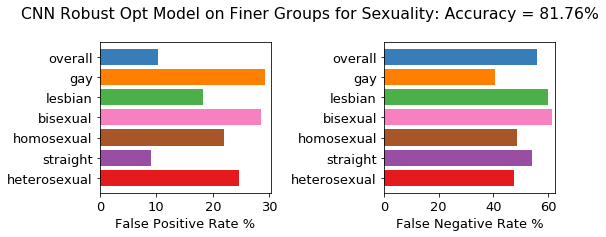

In [63]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="CNN Robust Opt Model on Finer Groups for Sexuality")

Notice that comments that contain the term "heterosexual" only constitute 0.03% of the dataset. It's therefore unsuprising that the robust optimization model has a false negative rate of 100% for this subgroup. Also notice that the comments containing the term "gay" and the comments containing the term "bisexual" have a higher false positive rate than the larger group of sexuality-related comments.

While one could consider training a model by directly constraining these tiny subgroups, such a model is likely to generalize very poorly to new data. A better strategy would be to instead collect more training data for each of these subgroups, and then control performance on these subgroups through a constrained or robust optimization set-up.

In [64]:
# We treat each identity term related to "religion" as a separate sub-group.
terms_grp = terms["religion"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,christian,0.84%,19.0%
1,muslim,0.70%,27.5%
2,jewish,0.17%,19.9%
3,buddhist,0.04%,21.6%
4,catholic,1.01%,12.1%
5,protestant,0.10%,9.0%
6,sikh,0.05%,13.2%
7,taoist,0.00%,6.7%


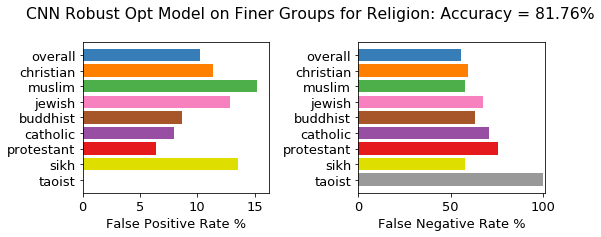

In [65]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="CNN Robust Opt Model on Finer Groups for Religion")

In [66]:
# We treat each identity term related to "race" as a separate sub-group.
terms_grp = terms["race"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,african,0.32%,17.5%
1,african american,0.08%,19.6%
2,black,1.82%,27.7%
3,white,3.05%,27.3%
4,european,0.30%,10.4%
5,hispanic,0.12%,21.2%
6,latino,0.06%,24.9%
7,latina,0.01%,11.4%
8,latinx,0.00%,8.3%
9,mexican,0.20%,20.4%


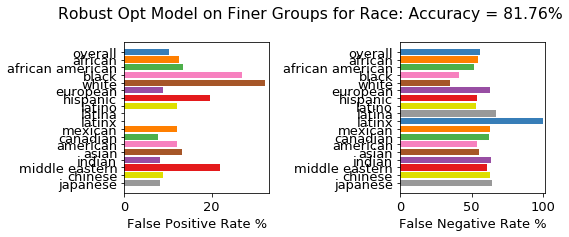

In [67]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="Robust Opt Model on Finer Groups for Race")

In [68]:
# We treat each identity term related to "gender identity" as a separate sub-group.
terms_grp = terms["gender identity"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


,Sub-group,Sub-group proportion,Label proportion
0,trans,1.77%,8.5%
1,transgender,0.12%,24.9%
2,cis,5.65%,20.2%
3,nonbinary,0.00%,nan%


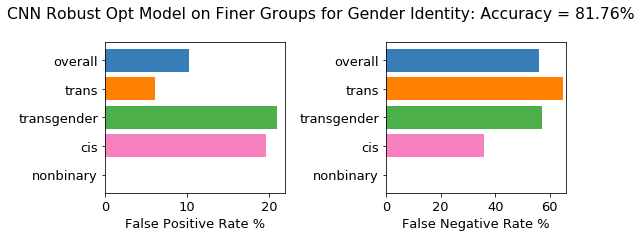

In [69]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="CNN Robust Opt Model on Finer Groups for Gender Identity")

In [70]:
# We treat each identity term related to "mental" as a separate sub-group.
terms_grp = terms["mental"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


,Sub-group,Sub-group proportion,Label proportion
0,depression,0.08%,10.1%
1,anxiety,0.05%,7.7%
2,bipolar,0.01%,14.0%
3,autism,0.02%,5.5%
4,schizophrenia,0.01%,10.3%
5,adhd,0.01%,8.2%
6,attention-Deficit,0.00%,nan%
7,agoraphobia,0.00%,0.0%
8,amnesia,0.01%,16.3%
9,asperger,0.00%,13.3%


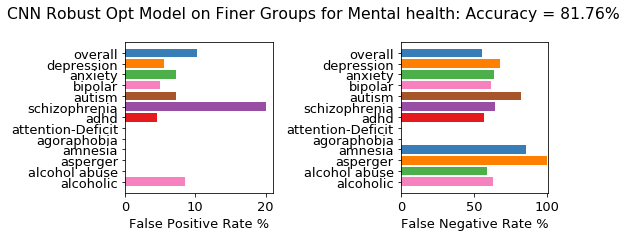

In [71]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="CNN Robust Opt Model on Finer Groups for Mental health")

In [72]:
# We treat each identity term related to "economic" as a separate sub-group.
terms_grp = terms["economic"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,poor,1.57%,13.4%
1,retired,0.21%,7.4%
2,unemployed,0.07%,9.7%
3,rich,1.32%,12.0%
4,homeless,0.53%,9.6%
5,layoffs,0.11%,6.7%


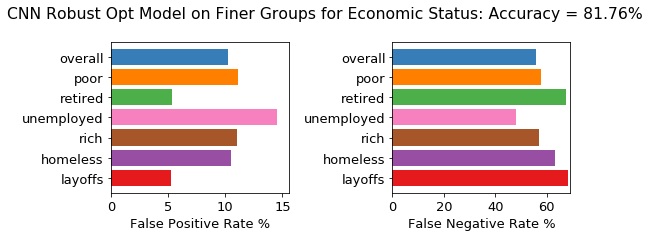

In [73]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="CNN Robust Opt Model on Finer Groups for Economic Status")

In [74]:
# We treat each identity term related to "physical" as a separate sub-group.
terms_grp = terms["physical"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,cancer,0.22%,15.9%
1,arthritis,0.01%,7.5%
2,injury,0.17%,7.3%
3,disability,0.07%,9.1%
4,alzheimer's,0.01%,6.7%
5,diabetes,0.03%,6.9%
6,infertility,0.00%,19.2%
7,hiv,0.09%,8.6%
8,parkinson,0.00%,3.8%
9,herpes,0.00%,20.3%


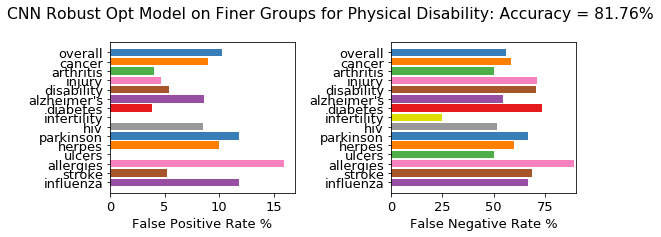

In [75]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="CNN Robust Opt Model on Finer Groups for Physical Disability")

# END CNN

# LSTM Performance on finer groups


In [91]:
# We treat each identity term related to "sexuality" as a separate sub-group.
terms_grp = terms["sexuality"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,gay,0.48%,32.1%
1,lesbian,0.05%,32.0%
2,bisexual,0.01%,27.1%
3,homosexual,0.21%,28.3%
4,straight,0.42%,14.6%
5,heterosexual,0.06%,25.2%


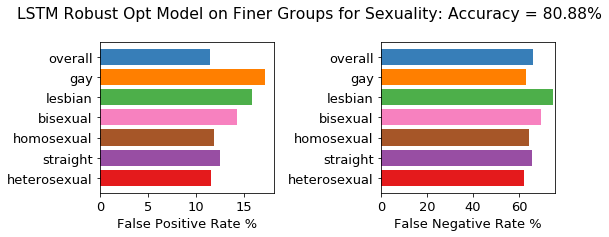

In [92]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="LSTM Robust Opt Model on Finer Groups for Sexuality")

In [94]:
# We treat each identity term related to "gender" as a separate sub-group.
terms_grp = terms["gender identity"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_sexuality[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


,Sub-group,Sub-group proportion,Label proportion
0,cancer,1.77%,8.5%
1,arthritis,0.12%,24.9%
2,injury,5.65%,20.2%
3,disability,0.00%,nan%


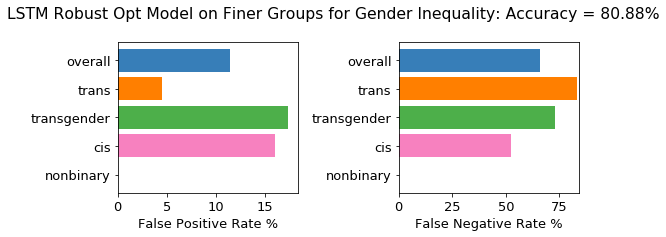

In [95]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="LSTM Robust Opt Model on Finer Groups for Gender Inequality")

In [96]:
# We treat each identity term related to "religion" as a separate sub-group.
terms_grp = terms["religion"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,christian,0.84%,19.0%
1,muslim,0.70%,27.5%
2,jewish,0.17%,19.9%
3,buddhist,0.04%,21.6%
4,catholic,1.01%,12.1%
5,protestant,0.10%,9.0%
6,sikh,0.05%,13.2%
7,taoist,0.00%,6.7%


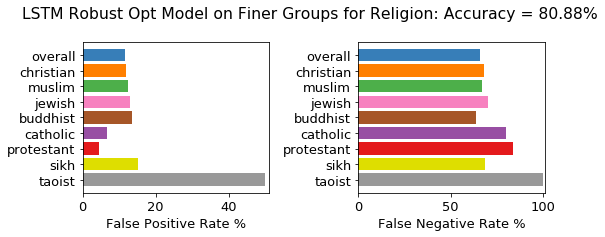

In [97]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="LSTM Robust Opt Model on Finer Groups for Religion")

In [98]:
# We treat each identity term related to "race" as a separate sub-group.
terms_grp = terms["race"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,african,0.32%,17.5%
1,african american,0.08%,19.6%
2,black,1.82%,27.7%
3,white,3.05%,27.3%
4,european,0.30%,10.4%
5,hispanic,0.12%,21.2%
6,latino,0.06%,24.9%
7,latina,0.01%,11.4%
8,latinx,0.00%,8.3%
9,mexican,0.20%,20.4%


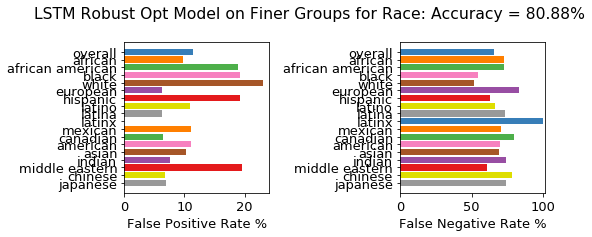

In [99]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="LSTM Robust Opt Model on Finer Groups for Race")

In [105]:
# We treat each identity term related to "mental" as a separate sub-group.
terms_grp = terms["mental"]

comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  


,Sub-group,Sub-group proportion,Label proportion
0,depression,0.08%,10.1%
1,anxiety,0.05%,7.7%
2,bipolar,0.01%,14.0%
3,autism,0.02%,5.5%
4,schizophrenia,0.01%,10.3%
5,adhd,0.01%,8.2%
6,attention-Deficit,0.00%,nan%
7,agoraphobia,0.00%,0.0%
8,amnesia,0.01%,16.3%
9,asperger,0.00%,13.3%


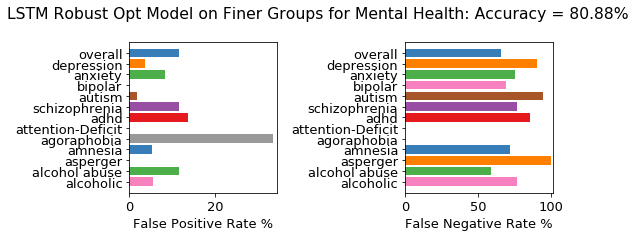

In [106]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="LSTM Robust Opt Model on Finer Groups for Mental Health")

In [101]:
# We treat each identity term related to "Physical" as a separate sub-group.
terms_grp = terms["physical"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_sexuality)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,cancer,0.22%,15.9%
1,arthritis,0.01%,7.5%
2,injury,0.17%,7.3%
3,disability,0.07%,9.1%
4,alzheimer's,0.01%,6.7%
5,diabetes,0.03%,6.9%
6,infertility,0.00%,19.2%
7,hiv,0.09%,8.6%
8,parkinson,0.00%,3.8%
9,herpes,0.00%,20.3%


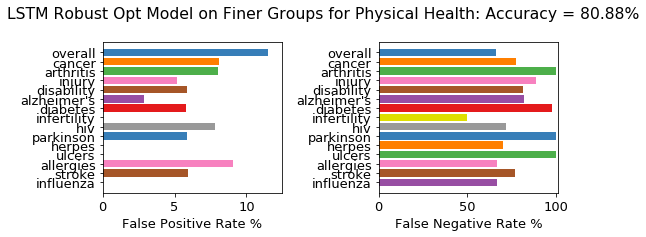

In [102]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="LSTM Robust Opt Model on Finer Groups for Physical Health")

In [107]:
# We treat each identity term related to "economic" as a separate sub-group.
terms_grp = terms["economic"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,poor,1.57%,13.4%
1,retired,0.21%,7.4%
2,unemployed,0.07%,9.7%
3,rich,1.32%,12.0%
4,homeless,0.53%,9.6%
5,layoffs,0.11%,6.7%


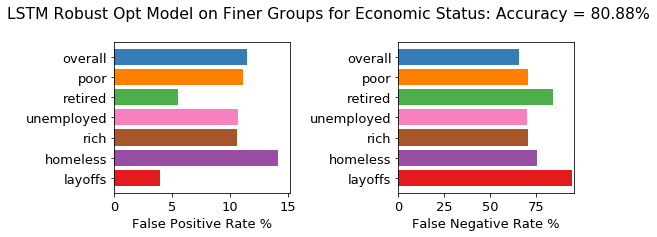

In [108]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="LSTM Robust Opt Model on Finer Groups for Economic Status")

# END LSTM##########

# BI-LSTM Performance on finer groups

In [123]:
# We treat each identity term related to "sexuality" as a separate sub-group.
terms_grp = terms["sexuality"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,gay,0.48%,32.1%
1,lesbian,0.05%,32.0%
2,bisexual,0.01%,27.1%
3,homosexual,0.21%,28.3%
4,straight,0.42%,14.6%
5,heterosexual,0.06%,25.2%


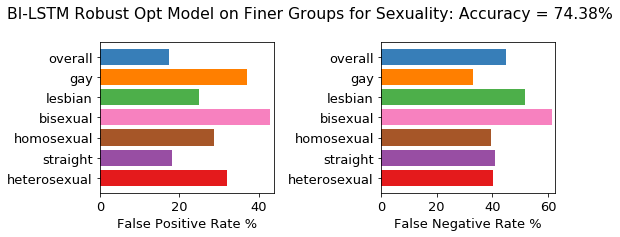

In [124]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="BI-LSTM Robust Opt Model on Finer Groups for Sexuality")

In [125]:
# We treat each identity term related to "gender" as a separate sub-group.
terms_grp = terms["gender identity"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_sexuality[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


,Sub-group,Sub-group proportion,Label proportion
0,cancer,1.77%,8.5%
1,arthritis,0.12%,24.9%
2,injury,5.65%,20.2%
3,disability,0.00%,nan%


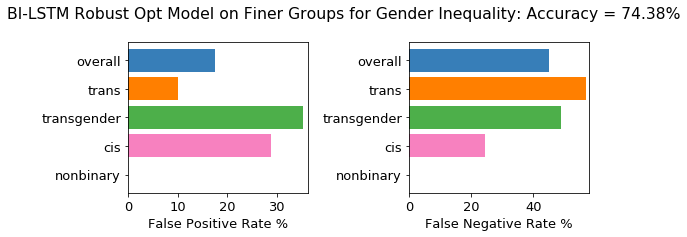

In [126]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="BI-LSTM Robust Opt Model on Finer Groups for Gender Inequality")

In [127]:
# We treat each identity term related to "religion" as a separate sub-group.
terms_grp = terms["religion"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,christian,0.84%,19.0%
1,muslim,0.70%,27.5%
2,jewish,0.17%,19.9%
3,buddhist,0.04%,21.6%
4,catholic,1.01%,12.1%
5,protestant,0.10%,9.0%
6,sikh,0.05%,13.2%
7,taoist,0.00%,6.7%


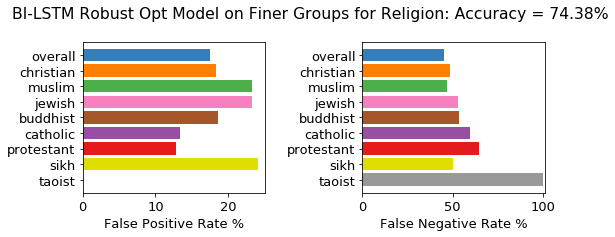

In [128]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="BI-LSTM Robust Opt Model on Finer Groups for Religion")

In [129]:
# We treat each identity term related to "race" as a separate sub-group.
terms_grp = terms["race"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,african,0.32%,17.5%
1,african american,0.08%,19.6%
2,black,1.82%,27.7%
3,white,3.05%,27.3%
4,european,0.30%,10.4%
5,hispanic,0.12%,21.2%
6,latino,0.06%,24.9%
7,latina,0.01%,11.4%
8,latinx,0.00%,8.3%
9,mexican,0.20%,20.4%


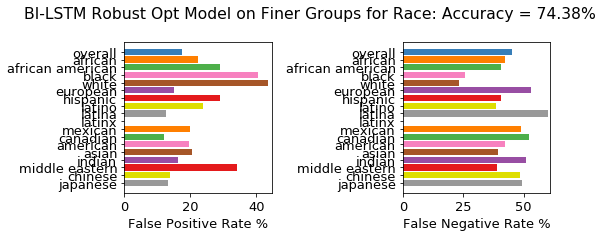

In [130]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="BI-LSTM Robust Opt Model on Finer Groups for Race")

In [132]:
# We treat each identity term related to "mental" as a separate sub-group.
terms_grp = terms["mental"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


,Sub-group,Sub-group proportion,Label proportion
0,depression,0.08%,10.1%
1,anxiety,0.05%,7.7%
2,bipolar,0.01%,14.0%
3,autism,0.02%,5.5%
4,schizophrenia,0.01%,10.3%
5,adhd,0.01%,8.2%
6,attention-Deficit,0.00%,nan%
7,agoraphobia,0.00%,0.0%
8,amnesia,0.01%,16.3%
9,asperger,0.00%,13.3%


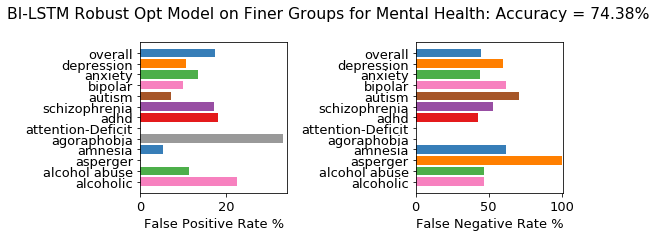

In [133]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="BI-LSTM Robust Opt Model on Finer Groups for Mental Health")

In [137]:
# We treat each identity term related to "Physical" as a separate sub-group.
terms_grp = terms["physical"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,cancer,0.22%,15.9%
1,arthritis,0.01%,7.5%
2,injury,0.17%,7.3%
3,disability,0.07%,9.1%
4,alzheimer's,0.01%,6.7%
5,diabetes,0.03%,6.9%
6,infertility,0.00%,19.2%
7,hiv,0.09%,8.6%
8,parkinson,0.00%,3.8%
9,herpes,0.00%,20.3%


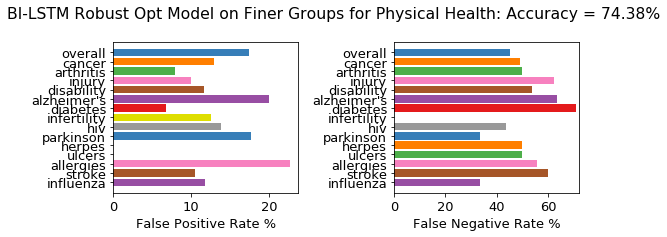

In [138]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="BI-LSTM Robust Opt Model on Finer Groups for Physical Health")

In [139]:
# We treat each identity term related to "economic" as a separate sub-group.
terms_grp = terms["economic"]

# Create a sub-group membership matrix.
comments_test = data_test["comment_text"]
subgroups_test = np.zeros((comments_test.shape[0], len(terms_grp)))
for ii in range(len(terms_grp)):
    subgroups_test[:, ii] = comments_test.str.contains(terms_grp[ii], case=False)

# Display sub-group statistics.
group_stats = []
for ii in range(len(terms_grp)):
    group_stats.append([terms_grp[ii],
                        "%.2f%%" % (subgroups_test[:, ii].mean() * 100),
                        "%.1f%%" % (labels_test[subgroups_test[:, ii] == 1].mean() * 100)])
group_stats_df = pd.DataFrame(
    group_stats, columns=["Sub-group", "Sub-group proportion", "Label proportion"])
group_stats_df

,Sub-group,Sub-group proportion,Label proportion
0,poor,1.57%,13.4%
1,retired,0.21%,7.4%
2,unemployed,0.07%,9.7%
3,rich,1.32%,12.0%
4,homeless,0.53%,9.6%
5,layoffs,0.11%,6.7%


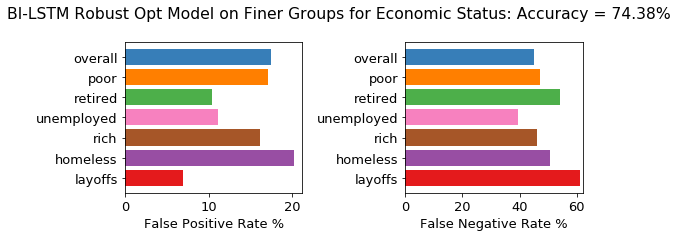

In [140]:
plot_metrics(labels_test, scores_test, subgroups_test,
             group_names=terms_grp, title="BI-LSTM Robust Opt Model on Finer Groups for Economic Status")

# END BI-LSTM